オリジナルの作成:

<html>
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>SageでTheanoのロジスティック回帰を試す</h1>
	<h2>参考サイト</h2>
	<p>	
		ここでは、
		 <a href="http://aidiary.hatenablog.com/">人工知能に関する断創録</a>
		 のTheanoに関連する記事をSageのノートブックで実装し、Thenoの修得を試みます。	
	</p>
	<p>
		今回は、Theanoのロジスティック回帰を以下のページを参考にSageのノートブックで試してみます。
		<ul>
			<li>
				<a href="http://aidiary.hatenablog.com/entry/20150519/1432038633">Theanoによる2クラスロジスティック回帰の実装</a>
			</li>
		</ul>		
	</p>
</html>

<html>
	<h2>２値分類</h2>
	<p>
		２値分類とは、入力xの値によって2種類に区別する問題です。２値の変数$y \in {0, 1}$で表現した場合、
		入力xからyの値を推定します。
	</p>
	<p>
		入力xを指定したとき、y=1となる事後確率$p(y=1|x)$をニューラルネットを使ってモデル化します。活性化関数gにはロジスティック関数を使用します。
$$
	h(x) = p(y=1|x) \approx g(x; w)
$$		
$$
	g(z) = \frac{1}{1 + e^{-z}}
$$
	</p>
	<p>
		べき乗の性質を使ったトリックを使うと事後分布$p(y|x; w)$をy=1とy=0の分布を使って
$$
		p(y|x) = p(y=1|x)^y p(y=0|x)^{1-y}
$$		
		と表すことができます。ここで$p(y=0|x) = 1 - h(x)$であることを使うとwの尤度は、
$$
		L(w) = \prod_{n=1}^N p(y_n | x_n; w) = \prod_{n=1}^N \{ h(x_n)\}^{y_n} \{1 - h(x_n) \}^{1-y_n}
$$		
		で与えられ、負の対数尤度は、以下のようになります。
$$
		E(w) = - \sum_{n=1}^N [y_n log\, h(x_n) + (1-y_n) log\{1 - h(x_n)\}]
$$		
	</p>
</html>

<html>
	<h3>必要なライブラリをインポート</h3>
	<p>
		最初に使用するライブラリをインポートします。
	</p>
</html>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

<html>
	<h3>訓練データのロード</h3>
	<p>
		訓練データex2data1.txtをdataディレクトリから読み込みます。
	</p>
</html>

In [2]:
# 訓練データをロード
data = np.genfromtxt("data/ex2data1.txt", delimiter=",")
data_x = data[:, (0, 1)]
data_y = data[:, 2]

# 訓練データ数
m = len(data_y)

<html>
	<h3>データの分布</h3>
	<p>
		y=1を赤、y=0を青の●(point)でプロットし、データの分布をみます。
	</p>
	<p>
		SageのGraphicsとpointを使うと簡単にデータの分布が可視化することができます。
	</p>
</html>

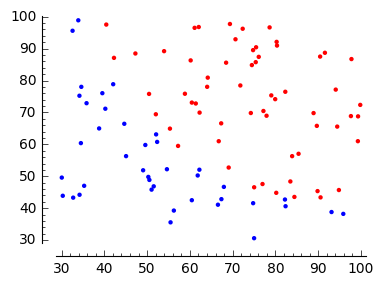

In [3]:
# データのプロット
data_plt = Graphics()
for i in range(m):
    if data_y[i] == 1:
        data_plt += point(data_x[i], rgbcolor='red')
    else:
        data_plt += point(data_x[i], rgbcolor='blue')
show(data_plt, figsize=4)

<html>
	<h3>コスト関数の自動微分</h3>
	<p>
		バイアス項もwに追加するために、入力データxの1列目に1の列を追加します。
	</p>
	<p>
		従って重みwは、$ w = [w_0, w_1, w_2]$となります。
	</p>
	<p>
		Theanoでコスト関数で定義します。
		<ul>
			<li>X: 訓練データを表す共有変数</li>
			<li>y: 訓練データの正解ラベルを表す共有変数</li>
			<li>w: 重み（パラメータ）を表す共有変数</li>
		</ul>
		人工知能に関する断創録のコメントは鋭く、T.dot(X, w)のXとwの順序が式と逆ではないかと指摘しており、
		これはXの行がサンプル、列が特徴をデータをまとめた行列なので、この順番になるのだそうです。
	</p>
	<p>
		g_wは、コスト関数をパラメータwで微分した数式を表している。
		このようにとても簡単に微分を定義することができるのがTheanoの特徴です。
</html>

In [4]:
# 訓練データの1列目に1を追加
data_x = np.hstack((np.ones((m, 1)), data_x))

# 訓練データを共有変数にする
X = theano.shared(np.asarray(data_x, dtype=theano.config.floatX), borrow=True)
y = theano.shared(np.asarray(data_y, dtype=theano.config.floatX), borrow=True)

In [5]:
# パラメータを共有変数にし、0で初期化
# 訓練データに1を加えたのでバイアスもwに含めてしまう
w = theano.shared(np.zeros(3, dtype=theano.config.floatX), name='w', borrow=True)
# コスト関数として負の対数尤度を定義
h = T.nnet.sigmoid(T.dot(X, w))
# 通常のコスト関数とは異なり1/mがファクターとして掛けてある。これがないと計算がnanとなり求まらない
cost = - (1.0/m)*T.sum(y * T.log(h) + (1 - y) * T.log(1 - h))

# コスト関数の微分
g_w = T.grad(cost=cost, wrt=w)

<html>
	<h2>Theanoによる勾配降下法の実装</h2>
	<p>
		学習率learning_rateと更新updatesにwの更新を定義し、theanoのfunctionとしてtran_modelを定義して、
		これを繰り返し実行するだけで勾配降下法が実現できてしまうところが本当にすごいです。
		<pre>
	# 訓練用の関数を定義
	train_model = theano.function(inputs=[], outputs=cost, updates=updates)
		</pre>	
		functionで指定したupdatesは、関数の実行後に指定された更新が自動的に行われる仕組みになっており、
		updatesには（共有変数, 更新式のシンボル）のペアが並ぶリストを指定します。	
	</p>
	<p>
		train_modelの戻り値には、cost関数の戻り値が返されます、これを収束の判定に使うことができます。
	</p>
	<p>
		今回は収束判定はしないで、30万回パラメータの更新を繰り返します。
	</p>
</html>

In [6]:
# モデルでnanが返された時に、以下のdetect_nanを使うことで、エラーになったデータの場所が特定できます！
# train_model = theano.function(inputs=[], outputs=cost, updates=updates, mode=theano.compile.MonitorMode(post_func=detect_nan))
# 
def detect_nan(i, node, fn):
    for output in fn.outputs:
        if (not isinstance(output[0], np.random.RandomState) and
            np.isnan(output[0]).any()):
            print '*** NaN detected ***'
            theano.printing.debugprint(node)
            print 'Inputs : %s' % [input[0] for input in fn.inputs]
            print 'Outputs: %s' % [output[0] for output in fn.outputs]
            break

In [7]:
# 勾配降下法
# パラメータ更新式
learning_rate = 0.001
updates = [(w, w - learning_rate * g_w)]

# 訓練用の関数を定義
train_model = theano.function(inputs=[], outputs=cost, updates=updates)

In [8]:
# 高度な収束判定はせずにiterations回だけ繰り返す
iterations = 300000
for iter in range(iterations):
    current_cost = train_model()
    if iter%20000 == 0:
        print iter, current_cost

0 0.69314718056
20000 0.547295463694
40000 0.488295709188
60000 0.445118809496
80000 0.41259440171
100000 0.387389522711
120000 0.367353248365
140000 0.351070505109
160000 0.337586093857
180000 0.326237734121
200000 0.316554335209
220000 0.308192817261
240000 0.300897944917
260000 0.294476164256
280000 0.288778154733


<html>
	<h3>結果をプロット</h3>
	<p>
		求められた重みwからy=0とy=1の境界を求めます。
$$
	w_0 + w_1 x_1 + w_2 x_2 = 0
$$	
		から
$$
	x_2 = -w_0/w_2 - w_1/w_2 x_1
$$		
		となります。これをSageのPlot関数を使って表示してみましょう。
	</p>
</html>

In [9]:
# 更新されたパラメータを表示
t = w.get_value()
print "w:", t

w: [-9.25573205  0.07960975  0.07329322]


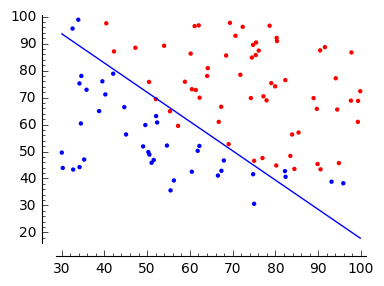

In [10]:
# 決定境界を描画
xmin, xmax = min(data_x[:,1]), max(data_x[:,1])
x1 = var('x1')
x2 = -t[0]/t[2] - t[1]/t[2]*x1
line_plt = plot(x2, [x1, xmin, xmax])
(data_plt + line_plt).show(figsize=4)

<html>
	<h3>Theanoによる確率的勾配降下法の実装</h3>
	<p>
		上記の勾配降下法は、誤差関数に各サンプルの誤差$E_n(w)$の和を求めています。この方法をバッチ学習（batch leaning）と呼びます。
$$
	E(w) = \sum_{n=1}^N E_n(w)
$$		
	</p>
	<p>
		これに対してサンプルからランダムに1個を抽出し、パラメータの更新を行う方式を確率的勾配降下法（stochastic gradient descent）
		と呼び、SGDと略します。SGDでのwの更新は以下のように行われます。
$$
	w^{(t+1)} = w^{(t)} - \epsilon \Delta E_n
$$				
	</p>
	<p>
		TheanoでSGDを実装するには、更新式を少し書き替えるだけで実現できます。
		<pre>
	# 訓練データのインデックスを表すシンボルを定義
	index = T.lscalar()			
	# コスト関数の微分をindex番目のデータのみ使うように修正
	h = T.nnet.sigmoid(T.dot(w, X[index,:]))
	cost = -y[index] * T.log(h) - (1 - y[index]) * T.log(1 - h)
	# 訓練用の関数の定義で、inputにindexを指定し、index番目の訓練データのみを使ってパラメータ更新する
	train_model = theano.function(inputs=[index], outputs=cost, updates=updates)
		</pre>		
	</p>
	<p>
		人工知能に関する断創録では、5000で計算していましたが、解がばらばなので、10000に増やして計算してみました。
	</p>
</html>

In [11]:
# 確率的勾配降下法
# 訓練データを再度設定
data_x = data[:, (0, 1)]
data_y = data[:, 2]

# 訓練データの1列目に1を追加
data_x = np.hstack((np.ones((m, 1)), data_x))

# データをシャッフル
p = np.random.permutation(m)
data_x = data_x[p, :]
data_y = data_y[p]

In [12]:
# 訓練データを共有変数にする
X = theano.shared(np.asarray(data_x, dtype=theano.config.floatX), borrow=True)
y = theano.shared(np.asarray(data_y, dtype=theano.config.floatX), borrow=True)

# パラメータを共有変数にし、0で初期化
# 訓練データに1を加えたのでバイアスもwに含めてしまう
w = theano.shared(np.zeros(3, dtype=theano.config.floatX), name='w', borrow=True)

# 訓練データのインデックスを表すシンボルを定義
index = T.lscalar()

In [13]:
# コスト関数の微分を構築
# 確率的勾配降下法なので全データの和ではなく、index番目のデータのみ使う
h = T.nnet.sigmoid(T.dot(w, X[index,:]))
cost = -y[index] * T.log(h) - (1 - y[index]) * T.log(1 - h)

# コスト関数の微分
g_w = T.grad(cost=cost, wrt=w)

# 更新式
learning_rate = 0.0005
updates = [(w, w - learning_rate * g_w)]

# 訓練用の関数を定義
# index番目の訓練データを使ってパラメータ更新
train_model = theano.function(inputs=[index], outputs=cost, updates=updates)

In [14]:
# 確率的勾配降下法
# 5000だと解がばらばらなので、10000に増やしてみた
max_epoch = 10000
for epoch in range(max_epoch):
    for i in range(m):
        current_cost = train_model(i)
    if epoch%500 == 0:
        print epoch, current_cost

# 更新されたパラメータを表示
t = w.get_value()
print "w:", t

0 0.00656547354551
500 0.00488465272555
1000 0.00423461457339
1500 0.00375663493527
2000 0.00336940545111
2500 0.00302347855601
3000 0.00270721707621
3500 0.00242221989684
4000 0.00217031969653
4500 0.00195027764774
5000 0.00175885229266
5500 0.00159234187297
6000 0.00144729745815
6500 0.00132066796387
7000 0.00120978340689
7500 0.00111232671324
8000 0.00102630974874
8500 0.000950045636937
9000 0.000882115355216
9500 0.000821331451974
w: [-14.40203227   0.14257697   0.13364604]


<html>
	<h3>決定境界の表示</h3>
	<p>
		解は勾配降下法の線の当たりをばらつきます。
	</p>
</html>

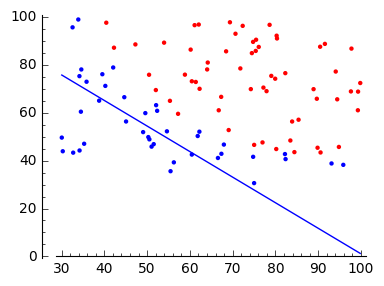

In [15]:
# 決定境界を描画
xmin, xmax = min(data_x[:,1]), max(data_x[:,1])
x1 = var('x1')
x2 = -t[0]/t[2] - t[1]/t[2]*x1
line_plt = plot(x2, [x1, xmin, xmax])
(data_plt + line_plt).show(figsize=4)